In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

# MNIST CNN

In [3]:
path = untar_data(URLs.MNIST)


In [4]:
path.ls()

[PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/testing')]

## DataBlock API exploded

In [5]:
imageList = ImageList.from_folder(path, convert_mode='L') #we need to pass L convert mode 'cause is not an rgb file'

In [6]:
imageList.items[0]

PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/9/36655.png')

In [7]:
defaults.cmap='binary'
#When we show images, normally it shows them in RGB. In this case, we want to use a binary color map

In [8]:
imageList

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/elvingomez/.fastai/data/mnist_png

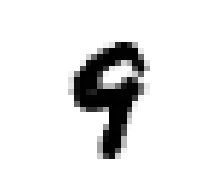

In [9]:
imageList[0].show()

In [10]:
splitData = imageList.split_by_folder(train='training', valid='testing')


Once you've got an image item list, you then split it into training versus validation. You nearly always want validation. If you don't, you can actually use the **.no_split** method to create an empty validation set. You can't skip it entirely. You have to say how to split, and one of the options is no_split.


In [11]:
splitData

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/elvingomez/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /Users/elvingomez/.fastai/data/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/9'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/0'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/7'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/6'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/1'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/8'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/4'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/3'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/2'),
 PosixPath('/Users/elvingomez/.fastai/data/mnist_png/training/5')]

In [13]:
labelList = splitData.label_from_folder()
labelList

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /Users/elvingomez/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,9,9,9,9
Path: /Users/elvingomez/.fastai/data/mnist_png;

Test: None

In [14]:
x, y = labelList.train[0]

9 torch.Size([1, 28, 28])


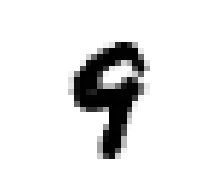

In [15]:
x.show()
print(y,x.shape)

In [16]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], []) # * is saying put both(padding & crop) transforms in this array

In [17]:
labelList = labelList.transform(tfms)
bs = 128

In [18]:
# not using imagenet_stats because not using pretrained model
data = labelList.databunch(bs=bs).normalize()

9


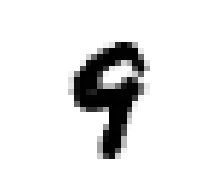

In [19]:
x.show()
print(y)

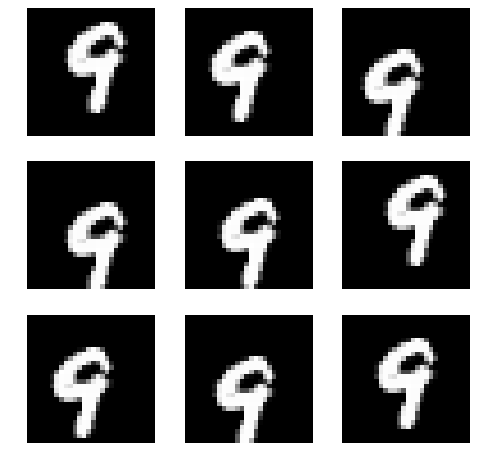

In [20]:
def _plot(i, j, ax):
    data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8, 8)) #fastai function

In [21]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

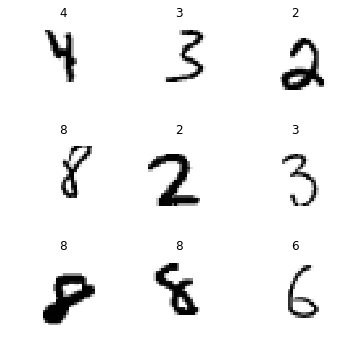

In [22]:
data.show_batch(rows=3, figsize=(5,5))

## Basic CNN with batch norm

In [23]:
def conv(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)

In [24]:
model = nn.Sequential( #image is 28 x 28
    #we have one channel coming in because it's a grayscale image with one channel
   conv(1, 8), #  image is now a 14 by 14 feature map with 8 channels, because of the stride = 2
    nn.BatchNorm2d(8), #Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid, flatten just means remove any unit axes
)

In [25]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [26]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [27]:
#xb = xb.cuda()

In [28]:
model(xb).shape

torch.Size([128, 10])

In [29]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


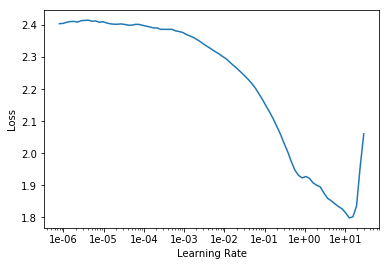

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.217104,0.203442,0.937500,00:22
1,0.125614,0.143745,0.955700,00:21
2,0.071751,0.038460,0.988200,00:21


### Refactor

In [32]:
#fastai thing
def conv2(inChannels, outChannels):
    return conv_layer(inChannels, outChannels, stride=2)

In [33]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [34]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
#that's exactly the same NN

In [35]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.238711,0.174271,0.947000,00:20
1,0.182403,0.170914,0.946200,00:20
2,0.176395,0.289779,0.910000,00:19
3,0.137083,0.202659,0.932400,00:19
4,0.116096,0.083538,0.972600,00:19
5,0.094407,0.074866,0.975700,00:19
6,0.083646,0.063830,0.979900,00:19
7,0.058810,0.041119,0.987100,00:19
8,0.047282,0.031915,0.989200,00:20
9,0.045985,0.030513,0.990200,00:20


## ResNet-ish

In [36]:
class ResBlock(nn.Module):
    def __init__(self, outChannels):
        super().__init__()
        self.conv1 = conv_layer(outChannels, outChannels)
        self.conv2 = conv_layer(outChannels, outChannels)
    def forward(self, x):
        return x + self.conv2(self.conv1(x)) #Residual learning
        

In [37]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [38]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [40]:
#Cleaner version
def convAndRes(inChannels, outChannels):
    return nn.Sequential(conv2(inChannels, outChannels), res_block(outChannels))

model = nn.Sequential(
    convAndRes(1, 8),
    convAndRes(8, 16),
    convAndRes(16, 32),
    convAndRes(32, 16),
    conv2(16, 10),
    Flatten()
)

In [41]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


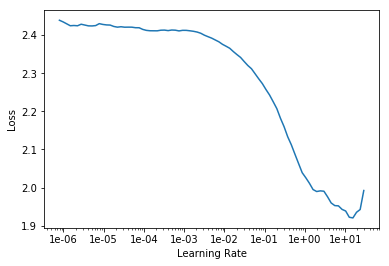

In [42]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.244988,0.145397,0.962500,01:24
1,0.141921,0.239141,0.932200,01:24
2,0.105444,0.078584,0.975100,01:24
3,0.084076,0.272455,0.911700,01:25
4,0.074697,0.174953,0.944900,01:24
5,0.057986,0.043623,0.986300,01:21
6,0.046172,0.045537,0.985600,01:22
7,0.043648,0.037004,0.988700,01:22
8,0.035380,0.029747,0.990800,01:21
9,0.027312,0.020609,0.993900,01:21


In [44]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________